References: 
- [Kaggle competition](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images)
- [Kaggle notebook](https://www.kaggle.com/darthmanav/alzheimer-s-classification-resnet-50) 

##Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

data_dir = '/content/gdrive/Shareddrives/CMPE297-TeamEquality/Data/AlzheimersDataset/'

Mounted at /content/gdrive


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import (
                                    ImageDataGenerator,
                                    load_img,
                                    img_to_array)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer,
                                     BatchNormalization,
                                     Dropout,
                                     Flatten,
                                     Dense, Activation, MaxPool2D, Conv2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Prepare dataset

In [ ]:
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  rotation_range=5,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  #zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = data_dir + 'train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = data_dir + 'train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = data_dir + 'test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


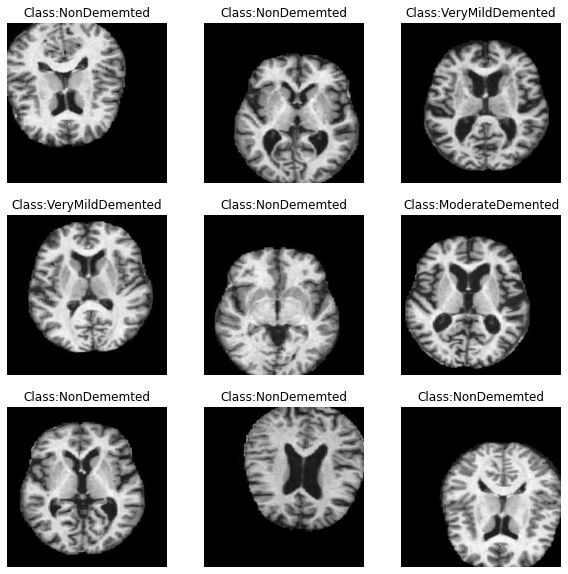

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

## Model building

In [ ]:
# Add Resnet base
base_model = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

# Freezing layers
for layer in base_model.layers:
    layer.trainable=False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0

## Define metrics

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Train model

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs = 20, 
                  verbose = 1,
                  callbacks=lr_scheduler)

Epoch 1/20
129/129 [==============================] - 1193s 9s/step - loss: 1.0868 - accuracy: 0.7482 - precision: 0.4931 - recall: 0.2543 - auc: 0.7703 - f1_score: 0.3317 - val_loss: 1.0847 - val_accuracy: 0.7456 - val_precision: 0.4526 - val_recall: 0.0841 - val_auc: 0.7790 - val_f1_score: 0.1390
Epoch 2/20
129/129 [==============================] - 72s 555ms/step - loss: 1.0449 - accuracy: 0.7569 - precision: 0.5262 - recall: 0.2765 - auc: 0.7843 - f1_score: 0.3597 - val_loss: 1.0249 - val_accuracy: 0.7869 - val_precision: 0.6667 - val_recall: 0.2952 - val_auc: 0.7895 - val_f1_score: 0.4033
Epoch 3/20
129/129 [==============================] - 71s 552ms/step - loss: 1.0321 - accuracy: 0.7632 - precision: 0.5505 - recall: 0.2872 - auc: 0.7884 - f1_score: 0.3739 - val_loss: 1.0052 - val_accuracy: 0.7825 - val_precision: 0.6114 - val_recall: 0.3568 - val_auc: 0.8031 - val_f1_score: 0.4488
Epoch 4/20
129/129 [==============================] - 71s 551ms/step - loss: 1.0180 - accuracy: 0.

Takes about 4.5 hours to train 20 epochs with no hardware accelerator, takes less than an hour with GPU

## Plot metrics

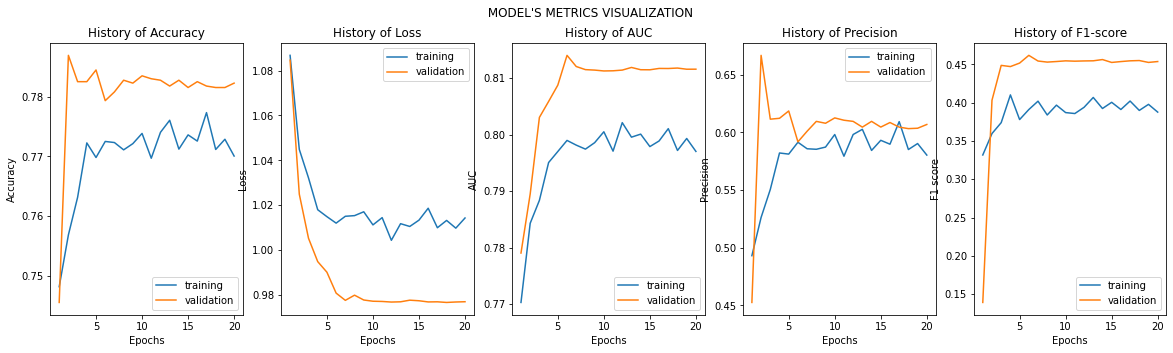

In [ ]:
def train_val_plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

train_val_plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [22]:
scores = model.evaluate(test_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

40/40 [==============================] - 10s 250ms/step - loss: 1.0054 - accuracy: 0.7717 - precision: 0.6231 - recall: 0.2197 - auc: 0.8038 - f1_score: 0.3228
Accuracy =  0.7716966271400452
Precision =  0.623059868812561
Recall =  0.21970289945602417
AUC =  0.8037754893302917
F1_score =  0.32284483313560486


##Inference

In [28]:
  dic = test_dataset.class_indices
  idc = {k:v for v, k in dic.items()}
  test_dir_path = '/content/gdrive/Shareddrives/CMPE297-TeamEquality/Data/AlzheimersDataset/test/'

def predict_img(target_label, img_file_path):
    img = load_img(test_dir_path+img_file_path, target_size = (224,224,3))
    img = img_to_array(img)
    img = img/255
    imshow(img)
    plt.axis('off')
    img = np.expand_dims(img,axis=0)
    predict_proba = model.predict(img)
    predict_class=np.argmax(predict_proba,axis=1)
    probability = round(np.max(predict_proba*100),2)
    print('Actual class: {}, Predicted class: {}, Probability: {}%'.format(target_label,idc[predict_class[0]], round(probability)))

Actual class: NonDemented, Predicted class: NonDemented, Probability: 53%


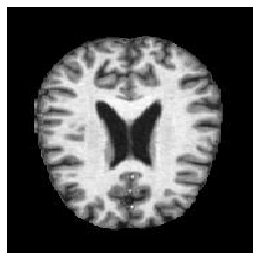

In [29]:
predict_img('NonDemented','NonDemented/26 (100).jpg')

Actual class: MildDemented, Predicted class: VeryMildDemented, Probability: 38%


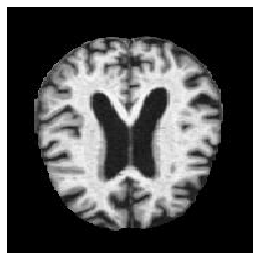

In [30]:
predict_img('MildDemented','MildDemented/26 (19).jpg')

Actual class: ModerateDemented, Predicted class: NonDemented, Probability: 38%


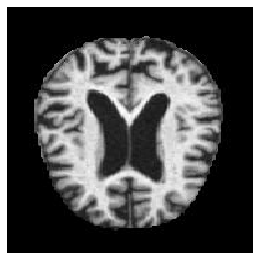

In [31]:
predict_img('ModerateDemented','ModerateDemented/27 (2).jpg')

Actual class: VeryMildDemented, Predicted class: NonDemented, Probability: 49%


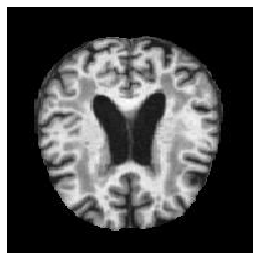

In [32]:
predict_img('VeryMildDemented','VeryMildDemented/26 (55).jpg')

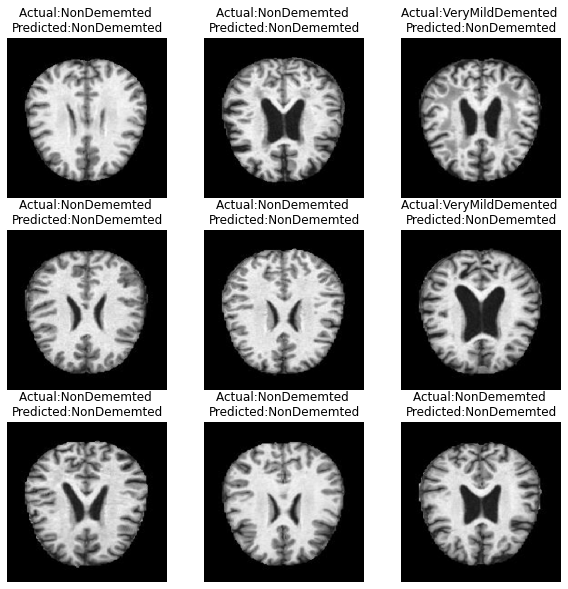

In [33]:
y_prob = model.predict(test_dataset)
y_pred = y_prob.argmax(axis=-1)
show_images(test_dataset,y_pred)